téléchargement préalable des modules requis

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import shutil, os

# 1. Construction d'un échantillon de la base train

On importe le dataframe complet de la base train, composé des plus de 33 000 images

In [2]:
df_train = pd.read_csv(r"C:\Users\jeann\OneDrive\Documents\scolaire\ENSAE\2A\S1\python\projet\base_complete.csv")

Calcul du taux de mélanomes malins au sein de cette base :

In [3]:
t = sum(df_train['target']==1) / len(df_train.index)
print("taux de malignité des mélanomes :", t*100, "%")

taux de malignité des mélanomes : 1.762965646320111 %


Comme nous l'avions déjà vu, le taux de malignité des mélanomes est très faible (1,76%). 

Aussi, dans un premier temps, pour faciliter la construction de premiers modèles, nous construisons une base réduite avec un taux de malignité bien supérieur (50%). Nous réduisons ainsi le nombre total d'images, ce qui nous permettra aussi de construire des modèles plus économes en mémoire vive pour l'instant.

Pour ce faire, on commence par définir une fonction d'échantillonnage simple :

In [4]:
np.random.seed

def simple_sampling(df, n) : 
    '''
    Cette fonction cree un échantillon simple de taille n à partir d'un dataframe. 
    Les lignes sélectionnées dans l'échantillon sont tirées aléatoirement, de manière équiprobable. 
        
        Cette fonction :
            - prend en parametres :
                - df : le dataframe à partir duquel on souhaite construire l'échantillon
                -  n : la taille de l'échantillon         
            - renvoie : le dataframe échantilloné, de n lignes  
            
        Exemple : 
            df = df_train
            n = 100
            => renvoie un dataframe de 100 lignes sélectionnées aléatoirement dans df_train
    '''
    rows = np.random.choice(df.index.values, n, replace = False)
    df_sample = df[df.index.isin(rows)]
    return df_sample   

On sépare ensuite la base initiale en une partie contenant tous les mélanomes malins, une autre contenant tous les mélanomes bénins

In [5]:
df_train_malin = df_train[df_train["target"] == 1]
df_train_benin = df_train[df_train["target"] == 0]

Puis on échantillonne chacune de ces sous-bases, avant de les réunir dans l'échantillon final

In [6]:
sample_malin = simple_sampling(df_train_malin, 200)
sample_benin = simple_sampling(df_train_benin, 200)

In [7]:
sample_train = sample_malin.append(sample_benin)

In [8]:
sample_train

,Unnamed: 0,image_id,patient_age,patient_sex,body_part,image_name,target,patient_id
234,234,ISIC_0188432,50,F,UPPER EXTREMITY,ISIC_0188432,1,IP_0135517
398,398,ISIC_0232101,60,M,TORSO,ISIC_0232101,1,IP_8349964
458,458,ISIC_0247330,65,F,LOWER EXTREMITY,ISIC_0247330,1,IP_3232631
550,550,ISIC_0274382,65,M,TORSO,ISIC_0274382,1,IP_7600629
606,606,ISIC_0286360,60,M,UPPER EXTREMITY,ISIC_0286360,1,IP_7729044
...,...,...,...,...,...,...,...,...
31839,31839,ISIC_9623772,45,M,UPPER EXTREMITY,ISIC_9623772,0,IP_9623174
32163,32163,ISIC_9714477,50,F,UPPER EXTREMITY,ISIC_9714477,0,IP_5221820
32714,32714,ISIC_9876004,45,F,HEAD/NECK,ISIC_9876004,0,IP_2769817
32957,32957,ISIC_9949745,55,M,LOWER EXTREMITY,ISIC_9949745,0,IP_3690477


In [10]:
sample_train.to_csv(r"C:\Users\jeann\OneDrive\Documents\scolaire\ENSAE\2A\S1\python\projet\sample.csv")

# 2. Analyse de l'échantillon
On analyse maintenant rapidement la base échantillon, pour comparer sa structure à celle de la base originale. On s'attend à une structure déformée, dans la mesure où on a considérablement sur-représenté les mélanomes malins. 

Vérifions les informations que l'on connaît déjà par construction :

In [149]:
sample_train.shape

(400, 8)

## 1- Analyses univariées

### a) âge

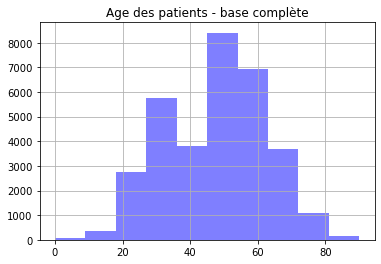

Moyenne : 46.87795347146492 
 Ecart type: 14.507820283196496


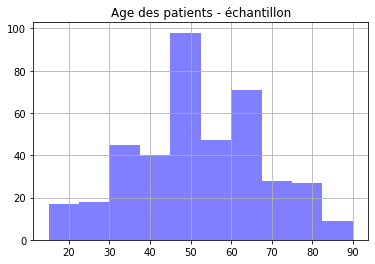

Moyenne : 50.6 
 Ecart type: 15.969582615782613


In [162]:
df_train['patient_age'].hist( facecolor='b', alpha=0.5)
plt.title('Age des patients - base complète')
plt.show()
print('Moyenne :', df_train['patient_age'].mean(), '\n', 'Ecart type:',  df_train['patient_age'].std())

sample_train['patient_age'].hist( facecolor='b', alpha=0.5)
plt.title('Age des patients - échantillon')
plt.show()
print('Moyenne :', sample_train['patient_age'].mean(), '\n', 'Ecart type:',  sample_train['patient_age'].std())

Contrairement à nos attentes, la distribution des âges ne semble pas trop affectée par notre échantillonnage. 

L'âge moyen est toute fois supérieur de presque 4 ans, ce qui était prévisible : nous avons sur-représenté les mélanomes malins dans notre échantillon, et les mélanomes malins sont portées dans les individus plus âgés de la moyenne. 

### b) sexe 

In [165]:
sample_train.groupby('patient_sex')['patient_id'].nunique()

patient_sex
F    145
M    190
Name: patient_id, dtype: int64

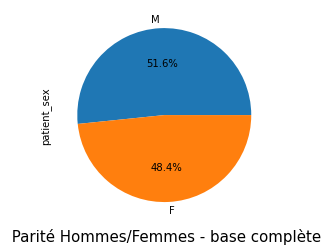

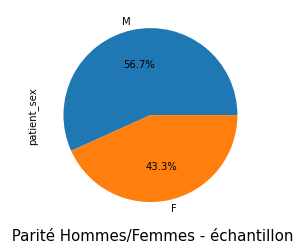

In [170]:
df_train["patient_sex"].value_counts().plot(kind='pie' , autopct='%1.1f%%')
plt.xlabel(' Parité Hommes/Femmes - base complète', fontsize=15)
plt.show()

sample_train["patient_sex"].value_counts().plot(kind='pie' , autopct='%1.1f%%')
plt.xlabel(' Parité Hommes/Femmes - échantillon', fontsize=15)
plt.show()

Notre échantillon sur-représente donc les hommes par rapport à la base originale : là-aussi prévisible, dans la mesure où les hommes sont sur-représentés parmis les porteurs de mélanomes malins. 

### c) parties du corps

In [172]:
sample_train['body_part'].value_counts()

TORSO              192
LOWER EXTREMITY     94
UPPER EXTREMITY     70
HEAD/NECK           30
SKIN                 8
PALMS/SOLES          4
ORAL/GENITAL         2
Name: body_part, dtype: int64

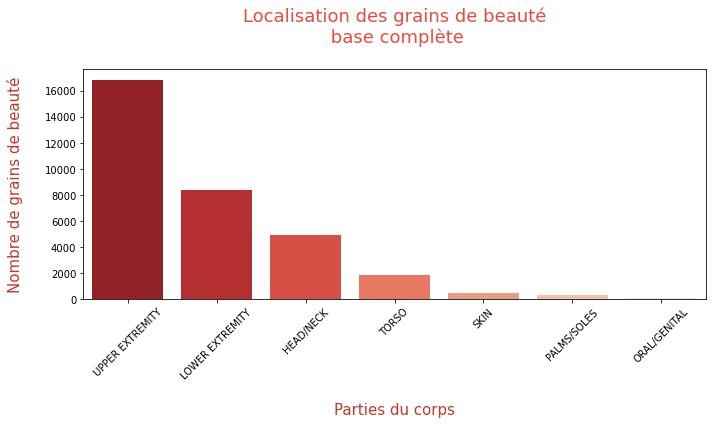

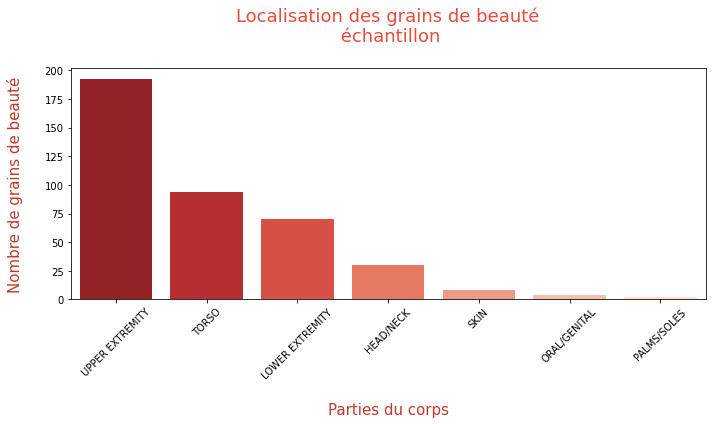

In [178]:
plt.figure(figsize=(10,6))
sns.barplot(x=df_train['body_part'].unique(), y=df_train['body_part'].value_counts(), palette="Reds_r")
plt.xlabel('\nParties du corps', fontsize=15, color='#c0392b')
plt.ylabel("Nombre de grains de beauté\n", fontsize=15, color='#c0392b')
plt.title("Localisation des grains de beauté\n base complète\n", fontsize=18, color='#e74c3c')
plt.xticks(rotation= 45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x=sample_train['body_part'].unique(), y=sample_train['body_part'].value_counts(), palette="Reds_r")
plt.xlabel('\nParties du corps', fontsize=15, color='#c0392b')
plt.ylabel("Nombre de grains de beauté\n", fontsize=15, color='#c0392b')
plt.title("Localisation des grains de beauté\n échantillon\n", fontsize=18, color='#e74c3c')
plt.xticks(rotation= 45)
plt.tight_layout()

Pas de différence notable dans la répartition des localisations des mélanomes. 

### d) mélanomes bénins et malins

Comme nous le savons par construction, les mélanomes malins sont considérablement sur-représentés dans notre échantillon.

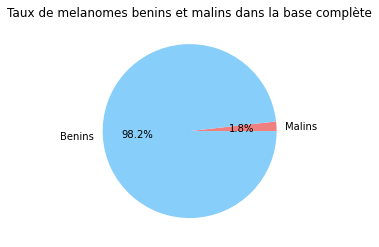

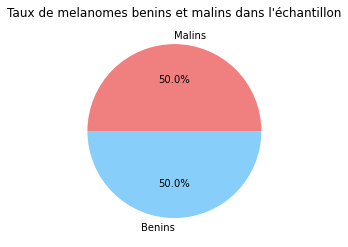

In [181]:
plt.pie([sum(df_train['target']==1),sum(df_train['target']==0)], labels = ['Malins','Benins'],colors = ['lightcoral','lightskyblue'],autopct='%1.1f%%')
plt.title("Taux de melanomes benins et malins dans la base complète")
plt.show()

plt.pie([sum(sample_train['target']==1),sum(sample_train['target']==0)], labels = ['Malins','Benins'],colors = ['lightcoral','lightskyblue'],autopct='%1.1f%%')
plt.title("Taux de melanomes benins et malins dans l'échantillon")
plt.show()

## 2- Analyses bivariées

### a) mélanomes et âge

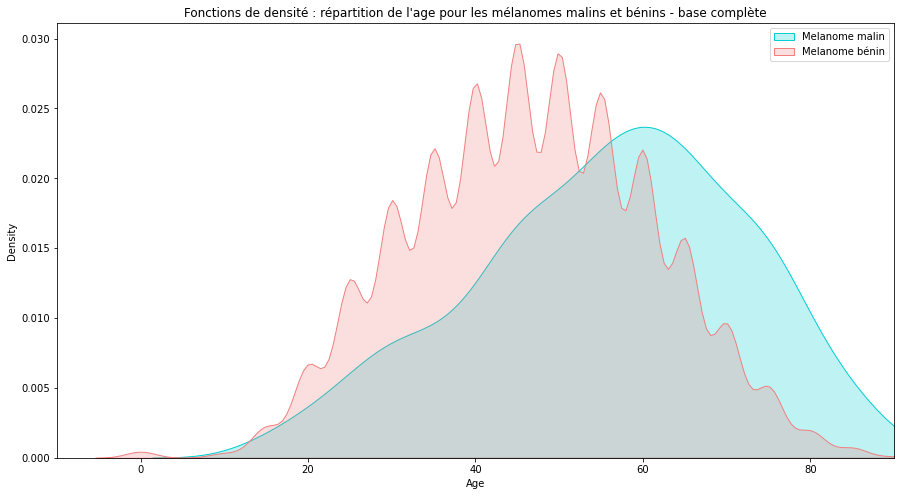

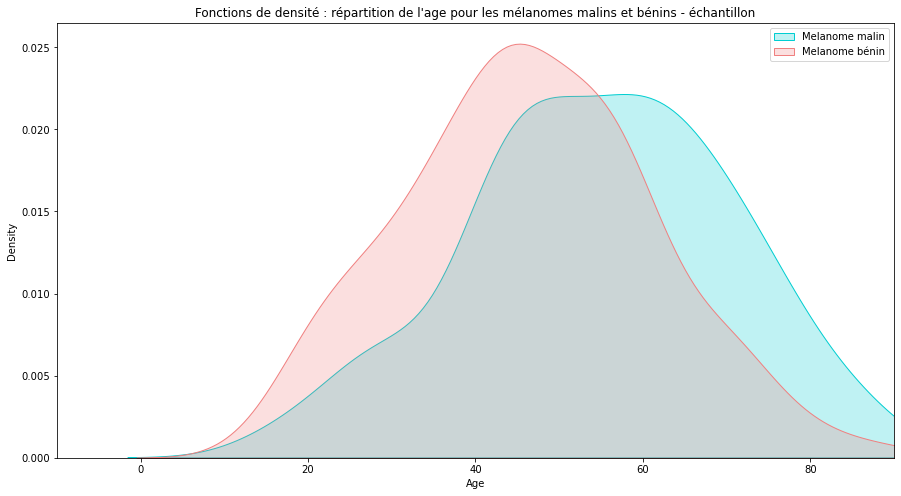

In [183]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(df_train["patient_age"][df_train.target == 1], color="darkturquoise", shade=True)
sns.kdeplot(df_train["patient_age"][df_train.target == 0], color="lightcoral", shade=True)
plt.legend(['Melanome malin', 'Melanome bénin'])
plt.title("Fonctions de densité : répartition de l'age pour les mélanomes malins et bénins - base complète")
ax.set(xlabel='Age')
plt.xlim(-10,90)
plt.show()

plt.figure(figsize=(15,8))
ax = sns.kdeplot(sample_train["patient_age"][sample_train.target == 1], color="darkturquoise", shade=True)
sns.kdeplot(sample_train["patient_age"][sample_train.target == 0], color="lightcoral", shade=True)
plt.legend(['Melanome malin', 'Melanome bénin'])
plt.title("Fonctions de densité : répartition de l'age pour les mélanomes malins et bénins - échantillon")
ax.set(xlabel='Age')
plt.xlim(-10,90)
plt.show()


La distribution des mélanomes bénins dans notre échantillon est lissée par rapport à la base complète. Sinon, les distributions semblent relativement similaires. 

### b) mélanomes et sexe

In [186]:
(sample_train.groupby('patient_sex')['target'].sum() / sample_train.groupby('patient_sex')['patient_id'].count() *100)

patient_sex
F    43.930636
M    54.625551
dtype: float64

C:\Users\jeann\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


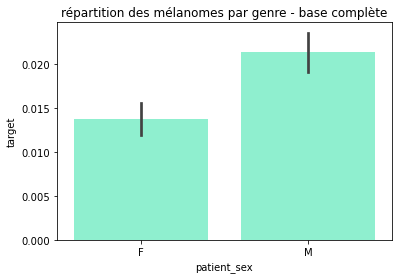

C:\Users\jeann\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


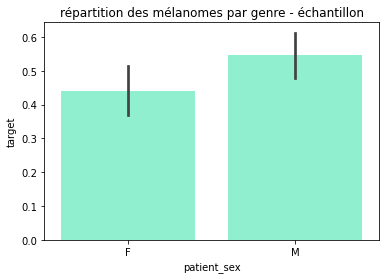

In [189]:
sns.barplot('patient_sex', 'target', data=df_train, color="aquamarine")
plt.title("répartition des mélanomes par genre - base complète")
plt.show()

sns.barplot('patient_sex', 'target', data=sample_train, color="aquamarine")
plt.title("répartition des mélanomes par genre - échantillon")
plt.show()

On remarque que le taux de malignité augmente pour chaque sexe - cohérent, car le taux de malignité général a augmenté. 
Les hommes restent plus touchés par les mélanomes malins que les femmes, même si la différence entre hommes et femmes se réduit légèrement.

### c) mélanomes et parties du coprs

In [190]:
(sample_train.groupby('body_part')['target'].sum() / sample_train.groupby('body_part')['patient_id'].count() *100)

body_part
HEAD/NECK           60.000000
LOWER EXTREMITY     47.872340
ORAL/GENITAL       100.000000
PALMS/SOLES         25.000000
SKIN                50.000000
TORSO               46.354167
UPPER EXTREMITY     58.571429
dtype: float64

C:\Users\jeann\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


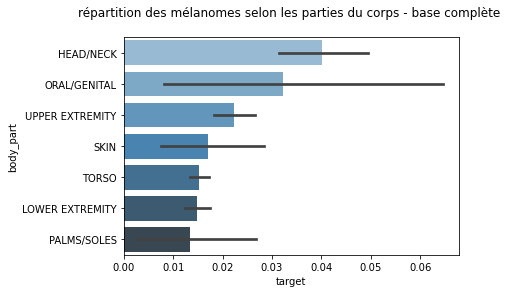

C:\Users\jeann\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


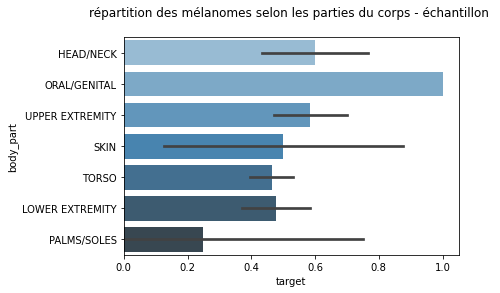

In [197]:
sns.barplot(df_train['target'], df_train['body_part'],palette='Blues_d', orient='h',  order=["HEAD/NECK", "ORAL/GENITAL","UPPER EXTREMITY","SKIN", "TORSO", "LOWER EXTREMITY", "PALMS/SOLES" ])
plt.title("répartition des mélanomes selon les parties du corps - base complète \n")
plt.show()

sns.barplot(sample_train['target'], sample_train['body_part'],palette='Blues_d', orient='h',  order=["HEAD/NECK", "ORAL/GENITAL","UPPER EXTREMITY","SKIN", "TORSO", "LOWER EXTREMITY", "PALMS/SOLES" ])
plt.title("répartition des mélanomes selon les parties du corps - échantillon \n")
plt.show()

La distribution des mélanomes malins sur les parties du corps semble perturbée par l'échantillonnage : les mélanomes sur les parties orales / génitales sont par exemple beaucoup plus malins dans l'échantillon que dans la base complète. 

Nous ne voyons pas d'explication particulière à ce phénomène, si ce n'est pas sélection au hasard qui pertubre la distribution. 

# 3. Création de deux dossiers distincts : Images melanomes benins et Images melanomes malins

In [12]:
def dossiers_images (path_image_dicom, path_malin, path_benin ) :
    """
    Cette fonction permet de transferer les images selectionnées dans l'échantillon vers un dossier 
    Images melanomes benins ou Images melanomes malins.
    /!\ Attention : Il faut préalablement créer les dossier "Images melanomes benins" et "Images melanomes malin" aux emplacements souhaités
    
    Elle prend en parametre :
        - path_image_dicom: chemin vers la base de donnée compléte des images au format dicom
        - lien vers le dossier Images melanomes malins 
        - lien vers le dossier Images melanomes benins
    
    Exemple : 
        path_image_dicom = 'C:/Users/louis/OneDrive/Documents/ENSAE/2A/Info/Projet melanome/train'
        path_malin ='C:/Users/louis/OneDrive/Documents/ENSAE/2A/Info/Projet melanome/Images echantillon training/Images melanomes malins'
        path_benin ='C:/Users/louis/OneDrive/Documents/ENSAE/2A/Info/Projet melanome/Images echantillon training/Images melanomes benins'
        dossiers_images (path_image_dicom, path_malin, path_benin ) 
    """
    for file in sample_malin.image_id :
        shutil.copy(path_image_dicom + '/' + file +'.dcm', path_malin + '/' + file +'.dcm')
    for file in sample_benin.image_id:
        shutil.copy(path_image_dicom + '/' + file +'.dcm', path_benin + '/' + file +'.dcm')
    return ('Les dossiers sont prets !')

In [13]:
path_image_dicom = r"D:\DICOM\train"
path_malin = r"D:\JPG\JPG_malin"
path_benin = r"D:\JPG\JPG_benin"
dossiers_images(path_image_dicom, path_malin, path_benin )

'Les dossiers sont prets !'